In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import fitsio as ft

import sys
sys.path.append('/home/mehdi/github/LSSutils')
from lssutils.utils import histogram_cell, make_overdensity

In [3]:
def makehp(hpix, value, nside):
    res_ = np.zeros(12*nside*nside)
    res_[hpix] = value
    return res_

class LinearMCMC:
    def __init__(self):
        
        c_ = np.load('/home/mehdi/github/linear/chains.npy', allow_pickle=True)
        self.chains = c_[300:, :, :].reshape(700*400, 22)
        
        shuff_ix = np.random.choice(self.chains.shape[0], size=self.chains.shape[0], replace=False)
        self.chains = self.chains[shuff_ix, :]
        self.stats = np.load('/home/mehdi/github/linear/stats_xy.npz', allow_pickle=True)
        
    def add_x(self, x, hpix):
        self.hpix = hpix
        self.xs = (x - self.stats['x'][0]) / self.stats['x'][1]
        
    def __call__(self, ix):
        #w_s = model(self.xs, self.chains[ix, :])
        w_s = model(self.xs, self.chains.mean(axis=0))# TODO: USE Max Posterior Es. (which doesn't need dropping the burn-in phase) instead of the mean
        w_ = (w_s*self.stats['y'][1]) + self.stats['y'][0]
        w_w = w_ / w_.mean()
        w_w = w_w.clip(0.5, 2.0)
        
        return makehp(self.hpix, w_w, 1024)

def plot_bin(cl):
    lmax = cl.size
    lb, clb = histogram_cell(cl)
    
    line, = plt.plot(np.arange(1, lmax), cl[1:], lw=1, alpha=0.2)
    plt.scatter(lb, clb, color=line.get_color(), ls='None', marker='s')
    
    
def model(x, theta):
    """ Linear model """
    return x.dot(theta[1:]) + theta[0]

def run_anafast(map1, map2, mask):
    
    map1_ = hp.ma(map1)
    map1_.mask = np.logical_not(mask)
    
    map2_ = hp.ma(map2)
    map2_.mask = np.logical_not(mask)
    
    return hp.anafast(map1_.filled(), map2_.filled())

In [4]:
df = ft.read('/home/mehdi/data/tanveer/dr8_elg_ccd_1024.fits')
print(df.dtype.names)

ngal = makehp(df['hpix'], df['label'], 1024)
syst = makehp(df['hpix'], df['features'][:, 0], 1024)
mask = makehp(df['hpix'], 1.0, 1024) > 0.5
frac = makehp(df['hpix'], df['fracgood'], 1024)

print(np.percentile(ngal[mask], [2.5, 97.5]))

('label', 'features', 'hpix', 'fracgood')
[ 3. 16.]


In [6]:
linm = LinearMCMC()
linm.add_x(df['features'], df['hpix'])

delta_sys = make_overdensity(syst*frac, frac, mask)
delta_null = make_overdensity(ngal, frac, mask)

cl_ss = run_anafast(delta_sys, delta_sys, mask)
cl_gs = {'null':run_anafast(delta_null, delta_sys, mask)}
cl_gg = {'null':run_anafast(delta_null, delta_null, mask)}

model_1 = linm(0)
delta_1 = make_overdensity(ngal, frac, mask, selection_fn=model_1)

cl_gg['mitig'] = run_anafast(delta_1, delta_1, mask)
cl_gs['mitig'] = run_anafast(delta_1, delta_sys, mask)

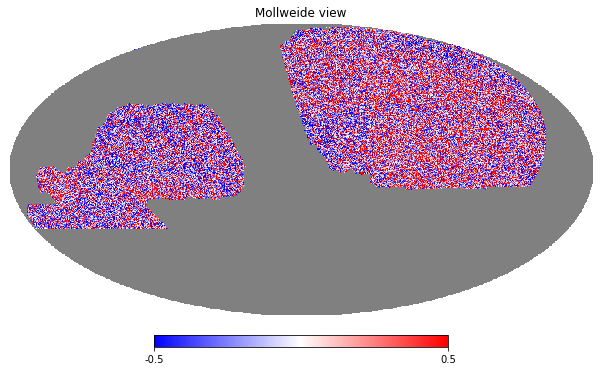

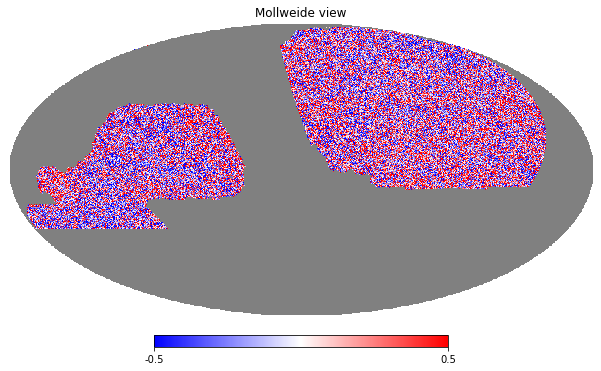

In [8]:
hp.mollview(delta_null, rot=-88, cmap=plt.cm.bwr, min=-0.5, max=0.5)
hp.mollview(delta_1, rot=-88, cmap=plt.cm.bwr, min=-0.5, max=0.5)

In [13]:
from lssutils.lab import MeanDensity

nbars = {}
nbar = MeanDensity(ngal, frac, mask, syst)
nbar.run()
nbars['null'] = nbar.output

nbar_ = MeanDensity(ngal, frac, mask, syst, selection=model_1)
nbar_.run()
nbars['mitig'] = nbar_.output

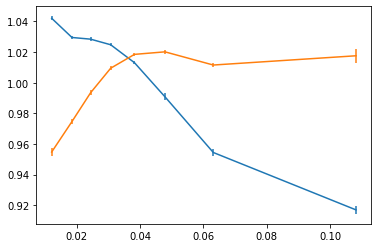

In [14]:
for name, nbar_i in nbars.items():
    plt.errorbar(nbar_i['bin_avg'], nbar_i['nnbar'], yerr=nbar_i['nnbar_err'], label=name)

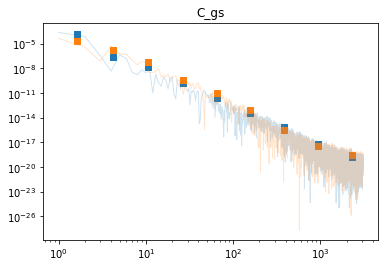

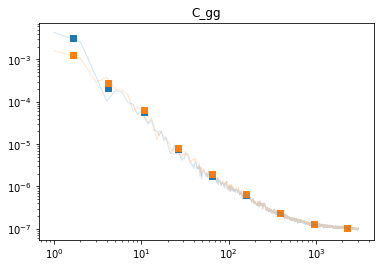

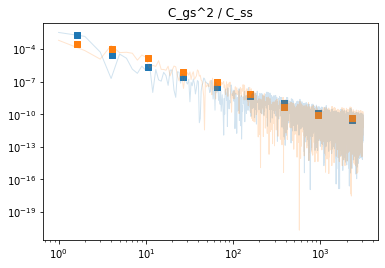

In [11]:
plt.title('C_gs')
plot_bin(cl_gs['null']**2)
plot_bin(cl_gs['mitig']**2)
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.title('C_gg')
plot_bin(cl_gg['null'])
plot_bin(cl_gg['mitig'])
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.title('C_gs^2 / C_ss')
plot_bin(cl_gs['null']**2/cl_ss)
plot_bin(cl_gs['mitig']**2/cl_ss)
plt.xscale('log')
plt.yscale('log')

(-1.0, 1.0)

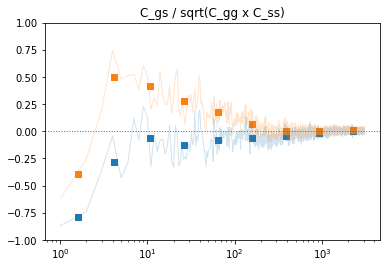

In [12]:
plt.title('C_gs / sqrt(C_gg x C_ss)')
plot_bin(cl_gs['null']/np.sqrt(cl_gg['null']*cl_ss))
plot_bin(cl_gs['mitig']/np.sqrt(cl_gg['mitig']*cl_ss))
plt.axhline(0.0, ls=':', lw=1)
plt.xscale('log')
# plt.yscale('log')
plt.ylim(-1.0, 1.)